In [1]:
%matplotlib inline
import glob
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import imageio
import skopi as sk
import pickle

import time
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.decomposition import PCA, IncrementalPCA, FastICA
from sklearn.linear_model import LinearRegression
from scipy.spatial.transform import Rotation as R

import os
import sys
sys.path.append('../src/')

In [2]:
set_name = '3iyf'
spi_dataset=f"/scratch/anassb/data/{set_name}_sim.h5"
spi_data = h5py.File(spi_dataset, 'r')
geom_path=f'/sdf/home/a/anassb/skopi/examples/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'
det = sk.PnccdDetector(geom=geom_path)

In [3]:
spi_data.keys()

<KeysViewHDF5 ['intensities', 'orientations', 'pixel_index_map', 'pixel_position_reciprocal', 'volume']>

In [4]:
n_images, n_panels, d_panel, _ = spi_data['intensities'].shape

d, d_slit = det.assemble_image_stack(spi_data['intensities'][0]).shape
det_mask = np.full(d_slit, True)
det_mask[d_panel:(d_panel + d_slit - d)] = np.full(d_slit - d, False)

n_batches = 10
batch_size = n_images // n_batches
batch_index = np.arange(n_images).reshape(n_batches, batch_size)

n_comp = 50

sub_ratio = 3
sub_d = d // sub_ratio

sub_index = sub_ratio * np.arange(sub_d)

# Storing the iPCA :

It can be done two ways : pickling the whole PCA object or saving only its "mean_", "components_" and "singular_values_" parameters. This second option is cheaper in terms of memory, but requires that all next operations be done manually instead of calling IncrementalPCA methods.

In [5]:
save_path = f'../save/ipca_{set_name}_sim_subratio_{sub_ratio}'

if not os.path.exists(save_path) :
    ipca = IncrementalPCA(n_components=n_comp)

    for index in tqdm(batch_index) :
        batch = det.assemble_image_stack_batch(spi_data['intensities'][index])[:, :, det_mask][:, sub_index][:,:, sub_index]
        ipca.partial_fit(batch.reshape(batch_size, sub_d ** 2))

    pca_file = open(save_path,'wb')
    pickle.dump(ipca, pca_file)
    pca_file.close()

else :
    pca_file = open(save_path,'rb')
    ipca = pickle.load(pca_file)
    pca_file.close()

# Basic PCA plots

In [6]:
plot_path = f'../images/{set_name}/'

if not os.path.exists(plot_path) :
    os.mkdir(plot_path)

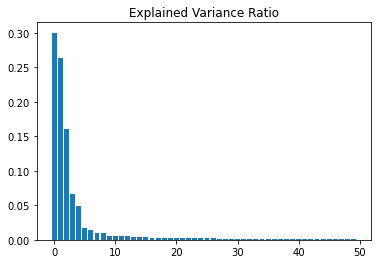

In [7]:
def EVRplot(pca) :   
    fig = plt.figure(figsize=(6, 4))
    plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
    plt.title('Explained Variance Ratio')
    plt.show()
    return fig

evr = EVRplot(ipca)
evr.savefig(plot_path + f'evr_subratio{sub_ratio}.png')

In [8]:
coordinates = []

for index in tqdm(batch_index) :
    batch_coord = ipca.transform(det.assemble_image_stack_batch(spi_data['intensities'][index])[:, :, det_mask][:, sub_index][:, :, sub_index].reshape(batch_size, sub_d ** 2))
    coordinates.append(batch_coord)
    
coordinates = np.concatenate(coordinates)
eigenimages = ipca.components_.reshape(n_comp, sub_d, sub_d)

100%|██████████| 10/10 [22:18<00:00, 133.84s/it]


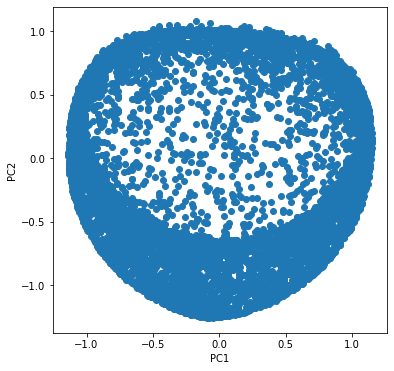

In [9]:
def PCplot(coord, pc_i, pc_j) :
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(coord[:, pc_i], coord[:, pc_j])
    plt.xlabel(f'PC{pc_i + 1}')
    plt.ylabel(f'PC{pc_j + 1}')
    plt.close()
    return fig

pc12 = PCplot(coordinates, 0, 1)
pc12.savefig(plot_path + f'pc12_subratio{sub_ratio}.png')

pc12

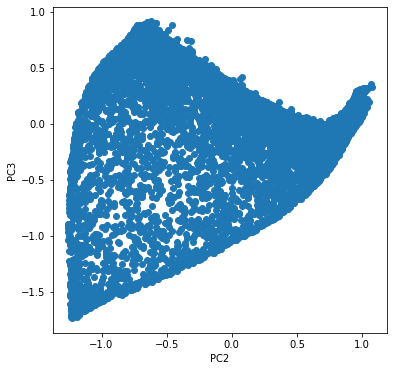

In [10]:
pc23 = PCplot(coordinates, 1, 2)
pc23.savefig(plot_path + f'pc23_subratio{sub_ratio}.png')

pc23

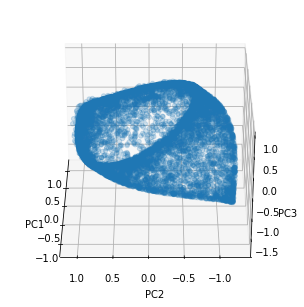

In [11]:
def PCplot3d(coord, pc_i, pc_j, pc_k, angle) :
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(coord[:, pc_i], coord[:, pc_j], coord[:, pc_k], alpha=0.2)
    ax.set_xlabel(f'PC{pc_i + 1}')
    ax.set_ylabel(f'PC{pc_j + 1}')
    ax.set_zlabel(f'PC{pc_k + 1}')
    ax.view_init(30, angle)
    plt.close()
    return fig

pc123 = PCplot3d(coordinates, 0, 1, 2, 180)
pc123.savefig(plot_path + f'pc123_subratio{sub_ratio}.png')

pc123

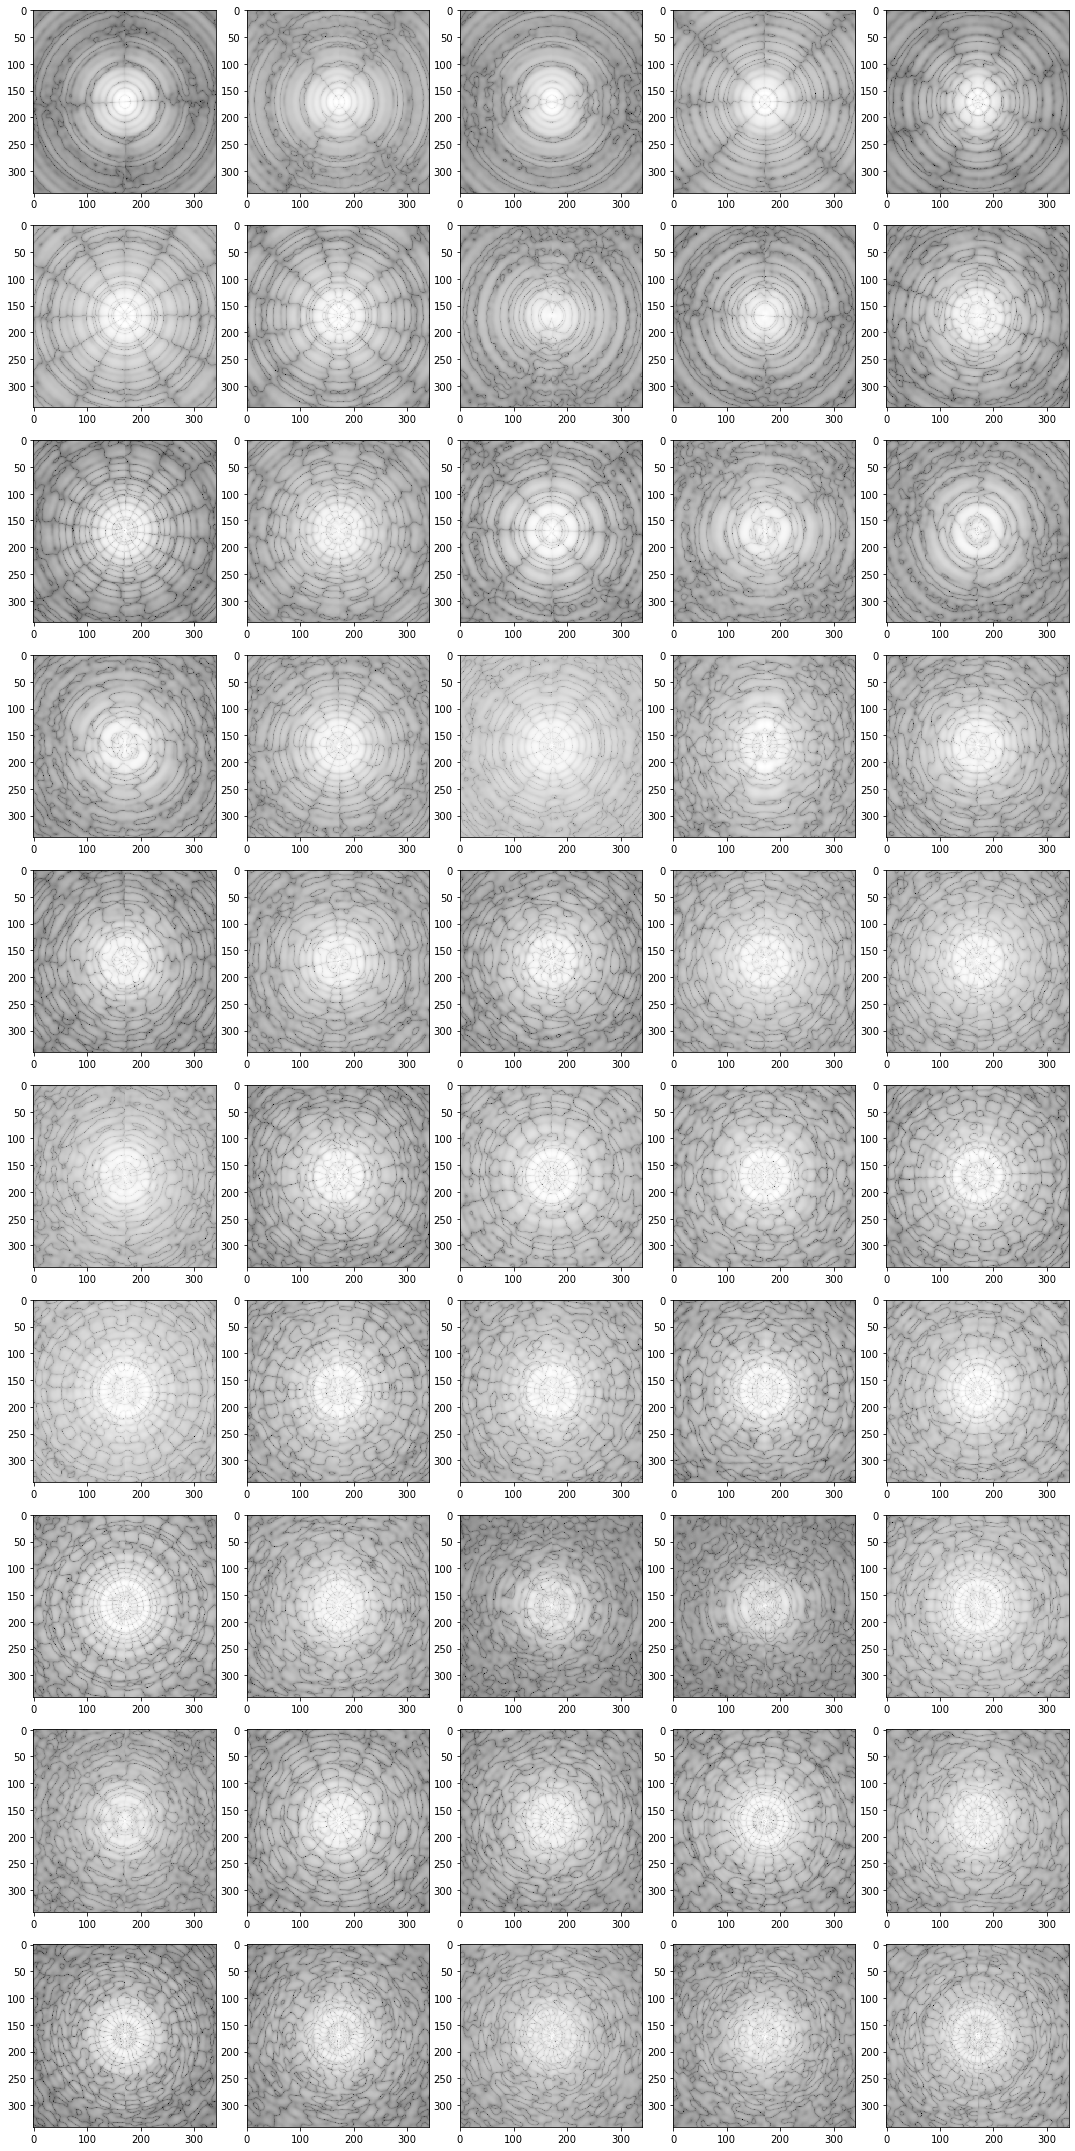

In [12]:
nrows=10
ncols=5
basis, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*(nrows//ncols)))
for i in range(nrows):
    for j in range(ncols):
        image = eigenimages[i*ncols+j]
        axs[i,j].imshow(np.abs(image), norm=LogNorm(), interpolation='none', cmap='Greys_r')
plt.tight_layout()
basis.savefig(plot_path + f'basis_subratio{sub_ratio}.png')

In [13]:
n_partial = 3
n_plot = 10
spi_mean = ipca.mean_

full_reconstruct = ipca.inverse_transform(coordinates).reshape(n_images, sub_d, sub_d)
partial_reconstruct = (np.dot(coordinates[:, :n_partial], ipca.components_[:n_partial]) + ipca.mean_).reshape(n_images, sub_d, sub_d)

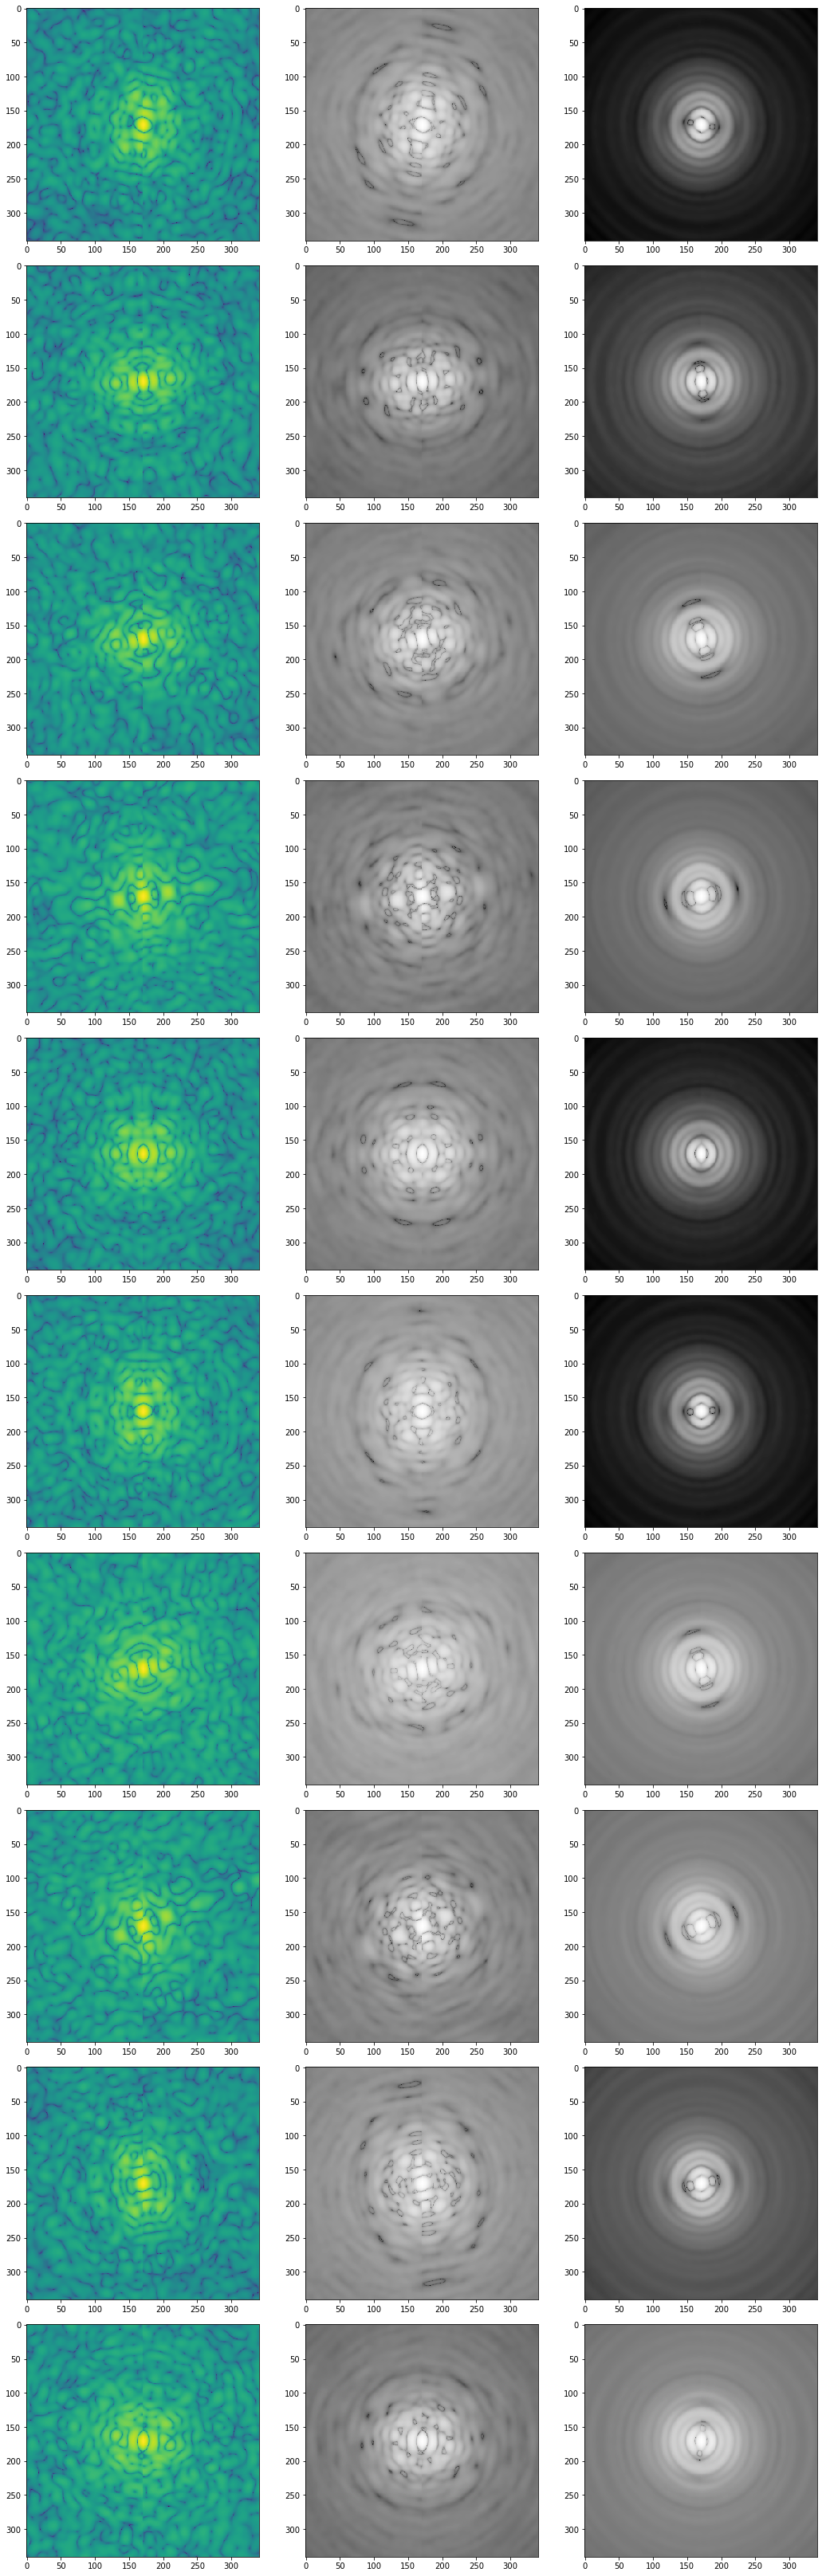

In [14]:
nrows=n_plot
ncols=3
reconstructions, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*(nrows//ncols)))
for i in range(nrows):
    image = det.assemble_image_stack(spi_data['intensities'][i])[:, det_mask][sub_index][:, sub_index]
    fullr = full_reconstruct[i]
    partialr = partial_reconstruct[i]
    axs[i,0].imshow(image, norm=LogNorm(), interpolation='none')
    axs[i,1].imshow(np.abs(fullr), norm=LogNorm(), interpolation='none', cmap='Greys_r')
    axs[i,2].imshow(np.abs(partialr), norm=LogNorm(), interpolation='none', cmap='Greys_r')
plt.tight_layout()
reconstructions.savefig(plot_path + f'reconstructions_subratio{sub_ratio}.png')

# Readjusting the cone

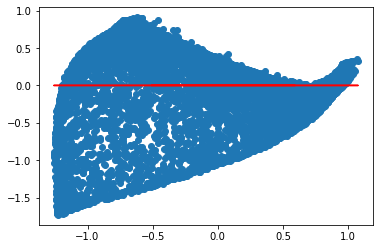

In [15]:
X = coordinates[:, 1].reshape(n_images, 1)
y = coordinates[:, 2]

reg = LinearRegression().fit(X, y)

a = reg.coef_
b = reg.intercept_
pred = reg.predict(coordinates[:, 1].reshape(n_images, 1))

plt.scatter(coordinates[:, 1], coordinates[:, 2])
plt.plot(coordinates[:, 1], pred, color='r')

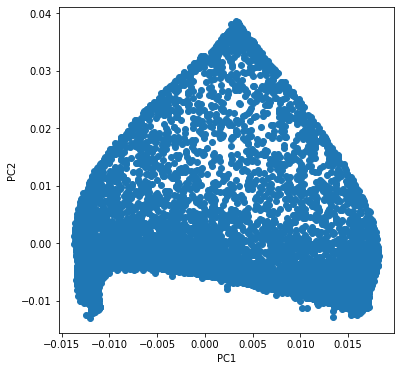

In [16]:
ica = FastICA(n_components=2, random_state=92)
trans = ica.fit_transform(coordinates[:, 1:3])

ica_plot = PCplot(trans, 0, 1)
ica_plot

# Bin similarity :

Let $B = \{u_1, \dots , u_d\}$ be a bin, with $u_i$ vectors representing the rotations of the images in the bin such that $||u_i||$ be the angle of the rotation and $\frac{1}{||u_i||} u_i$ its axis.

Let $M$ the correlation matrix of $B$, we measure the similarity of rotation axes in $B$ by :

$$J = \frac{||M||_{L^2}}{d}$$

We thus have $J = 1 \Leftrightarrow M = \begin{bmatrix} 
    1 & \dots & 1 \\
    \vdots & \ddots & \\
    1 &        & 1 
    \end{bmatrix}$
    
We consider $argmax_{u \in B} \sum_{1 \leq i \leq d} \frac{|<u, u_i>|}{||u|| \cdot ||u_i||}$ to be the center axis of $B$.

In [17]:
n_bins = 20
min_bin = trans[:, 1].min()
max_bin = trans[:, 1].max()
bins = np.linspace(min_bin, max_bin, n_bins + 1)
bin_indexes = np.array([(trans[:, 1] >= bins[i]) * (trans[:, 1] < bins[i + 1]) for i in range(n_bins)])

In [18]:
def as_normrotvec(quat) :
    rotvec = R(quat).as_rotvec()
    return rotvec/norm(rotvec)

def rotvec_cor(r1, r2) :
    return np.abs(r1.dot(r2))

def bin_cor(b) :
    rotvec = [as_normrotvec(x) for x in spi_data['orientations'][:][b]]
    len_bin = len(rotvec)
    cor = np.zeros((len_bin, len_bin))
    for i in range(len_bin) :
        for j in range(len_bin) :
            cor[i, j] = rotvec_cor(rotvec[i], rotvec[j])
    return cor

def find_center_axis(cor) :
    metric = cor.sum(axis=1)
    return np.argmax(metric)
    
def similarity_score(cor) :
    return norm(cor)/len(cor)

def diff_angle(quat1, quat2) :
    r_diff = (R(quat2) * R(quat1).inv()).as_rotvec()
    theta = norm(r_diff)
    if theta <= np.pi / 2 :
        return theta
    return theta - np.pi

In [19]:
cors = [bin_cor(b) for b in bin_indexes]

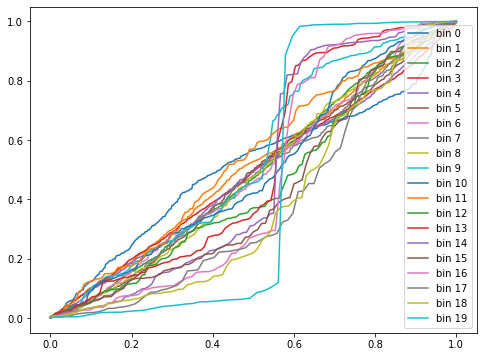

In [20]:
fig = plt.figure(figsize=(8, 6))
for i in range(n_bins) :
    b = bin_indexes[i]
    scal_rotvec = cors[i][0]
    x_bin = np.linspace(0, 1, b.sum())
    plt.plot(x_bin, np.sort(scal_rotvec), label=f"bin {i}")
plt.legend(loc='best')
plt.show()

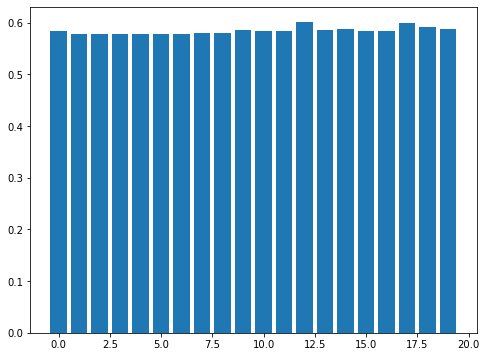

In [21]:
fig = plt.figure(figsize=(8, 6))
similarity_scores = [similarity_score(c) for c in cors]
x_bar = np.arange(n_bins)
plt.bar(x_bar, similarity_scores)
plt.show()

In [22]:
center_axes = [find_center_axis(cor) for cor in cors]
angles = []

for i in range(n_bins) :
    b = bin_indexes[i]
    len_bin = b.sum()
    axis = center_axes[i]
    quats = spi_data['orientations'][:][b]
    quat1 = quats[axis]
    theta = np.zeros(len_bin)
    for j in range(len_bin) :
        quat2 = quats[j]
        theta[j] = diff_angle(quat1, quat2)
    angles.append(theta)

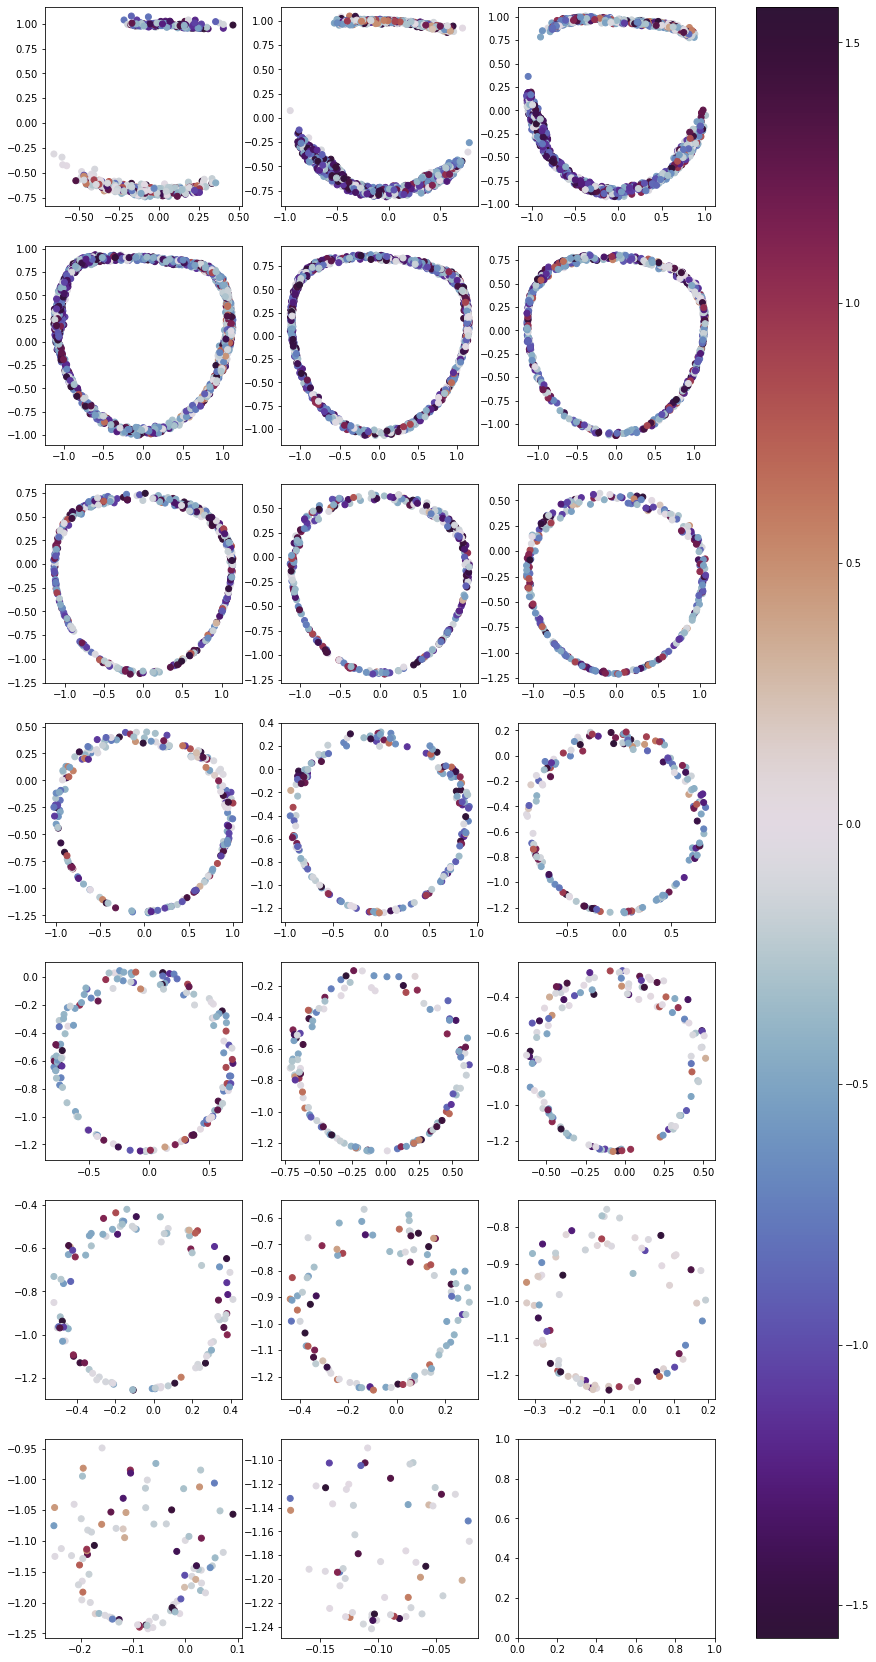

In [23]:
ncols = 3
nrows = int(np.ceil(n_bins/ncols))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15*(nrows//ncols)))
for i in range(nrows):
    for j in range(ncols) :
        if i * ncols + j < n_bins :
            b = bin_indexes[i * ncols + j]
            im = axs[i, j].scatter(coordinates[b][:, 0], coordinates[b][:, 1], c=angles[i * ncols + j], cmap='twilight_shifted')

fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

# Cone exploration

In [24]:
gif_folder = f'../images/{set_name}/gif/'
if not os.path.exists(gif_folder) :
    os.mkdir(gif_folder)

In [25]:
def angle_2pts(center, point) :
    delta = point - center
    z = complex(real = delta[0], imag=delta[1])
    return np.angle(z)

def angle_array(points) :
    center = points.mean(axis=0)
    return np.array([angle_2pts(center, pt) for pt in points])

In [26]:
bin_angles = [angle_array(coordinates[b, :2]) for b in bin_indexes]
bin_angle_indexes = [np.argsort(bin_angles[i]) for i in range(n_bins)]
bin_angle_indexes[0].shape

(472,)

In [27]:
def BinImagePlot(b, k_bin) :
    true_index = np.arange(n_images)[b][k_bin]
    image = det.assemble_image_stack(spi_data['intensities'][true_index])[:, det_mask][sub_index][:, sub_index]
    k_mask = (np.arange(b.sum()) == k_bin)
    not_k_mask = np.logical_not(k_mask)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax1.scatter(coordinates[b][not_k_mask, 0], coordinates[b][not_k_mask, 1], color='blue', alpha=0.3)
    ax1.scatter(coordinates[b][k_mask, 0], coordinates[b][k_mask, 1], s=200, color='r', marker='^')
    ax2.imshow(image, norm=LogNorm(), interpolation='none')
    
    ax1.set_title('Bin Plot')
    ax1.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('Original Image')
    plt.close()
    return fig

In [28]:
def bin_lap_gif(b_idx, n_frames) :
    bin_lap_folder = gif_folder + 'bin_lap/'
    if not os.path.exists(bin_lap_folder) :
        os.mkdir(bin_lap_folder)
    
    b = bin_indexes[b_idx]
    len_bin = b.sum()
    frames = np.linspace(0, len_bin, num=n_frames, endpoint=False, dtype='int32')
    frames = bin_angle_indexes[b_idx][frames]
    
    gif_name = os.path.join(gif_folder, f'bin{b_idx}_subratio{sub_ratio}.gif')
    images = []
    
    for k in tqdm(frames) :
        filename = os.path.join(bin_lap_folder, f'{k}.png')
        BinImagePlot(b, k).savefig(filename)
        images.append(imageio.imread(filename))
        os.remove(filename)
        
    imageio.mimsave(gif_name, images, fps=10)

In [29]:
bin_lap_gif(0, 200)

100%|██████████| 200/200 [00:46<00:00,  4.27it/s]


# Quaternion trajectories

In [30]:
def closest_point(quat) :
    return np.argmin(norm(quat - spi_data['orientations'][:], axis=1))

def point_mask(idx, d) :
    mask = np.full(d, False)
    mask[idx] = True
    return mask

def traj_mask(trajectory, d) :
    mask = np.full(d, False)
    for quat in trajectory :
        mask[closest_point(quat)] = True
    return mask

def plot_trajectory(trajectory) :
    mask = traj_mask(trajectory, n_images)
    remain = np.logical_not(mask)

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(coordinates[remain, 0], coordinates[remain, 1], coordinates[remain, 2])
    ax.scatter(coordinates[mask, 0], coordinates[mask, 1], coordinates[mask, 2], color='red')
    ax.set_xlabel(f'PC{1}')
    ax.set_ylabel(f'PC{2}')
    ax.set_zlabel(f'PC{3}')
    plt.close()
    
    return fig

In [31]:
def traj_gif(trajectory, space) : 
    traj_folder = f'../images/{set_name}/gif/trajectories/'
    if not os.path.exists(traj_folder) :
        os.mkdir(traj_folder)

    with imageio.get_writer('../images/gif/trajectory.gif', mode='I') as writer:
        for i in range(len(traj)//space) :
            filename = traj_folder + f'{i}.png'
            plot_trajectory(traj[:i*space]).savefig(filename)
            image = imageio.imread(os.path.join(traj_folder, filename))
            writer.append_data(image)          


colore par la norme des quaternions

retrouver vecteur principal

norme minimale

moyenne : tourne puis somme

2 angles : angle polaire le long de la bin
    
tenir fred au courant

# spi :

vérifier cône sur autres datasets

prendre reférences sur la même ligne du cône

lier angle image et angle/position cône (voir papier : plot)

paralléliser pca

creuser théorie variétés

comparer visuellement images d'1 même bin

slicer verticalement

rotation SO2

trajectoire sur le cône d'1 même image qu'on tourne

# cryoem : 

extraire angles et defocus (quantifier)

appliquer méthodes non-linéaires sur 1res composantes pca pour retrouver angles et defocus

documenter le notebook

# Suite :

idée de fred

nouveaux datasets d'Ariana : généralité du cône ? hypothèse géométrique vérifiée

accélérer PCA incrémentale

slides préciser suite de deeban

montrer 1 cryoem 1 spicdi pour présenter les datasets

présenter l'idée : reconstruire 3d

culture légère méthodes classiques reconstruction 3D : chaque image = projection 2D d'1 image 3D

2 méthodes = seules au monde imagerie particule unique

modèle de formation d'image que je comprends pas, mais pt commun = transition 3d-2d encodée dans l'image et on veut remonter à l'image 3d

problème inverse : 3d -> 100000 2d, moi 100000 2d -> 3d

discuter des boites noires : modèle formation image + techniques résolution pb inverse

score de symétrie d'une image + norme rotvec / colorer le cône

énumérer toutes les formes géométriques possibles pour les molécules et voir leur espace latent

pc123 -> modèle ML -> quaternions training

ce qu'il se passe si on est presque symétrique mais qu'on l'est pas ?

tourner les images selon leur angle PC12 et ploter la comparaison + moyenner

PC3 = tilt si on a un cylindre ? plotter PC3 contre angle d'euler

crop?

plotter composantes ica

______________________________


Comment mesurer obsolescence PCA ? si on actualise seulement toutes les k images

cropper et ica

cryoem r theta plot avec angle image : R2 et pvalue